<a href="https://colab.research.google.com/github/jgabry/bayes-workflow-book/blob/master/jupyter/Golf_Putting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bayesian Workflow - Golf Putting Ability

This IR notebook contains a simple nonlinear regression model of golf putting ability.  It provides gentle introduction to Stan modeling and the practice of model building and model expansion.

## About this notebook

In each session, you must run the code cells in order, in order to introduce all packages, files, and variables into the runtime environment.  If you have a Google account, you can run this notebook using [Google Colaboratory](https://research.google.com/colaboratory/faq.html), the free, cloud-based Jupyter notebook environment.  This [handout on Jupyter and RStudio](https://cse.buffalo.edu/~bina/cse487/spring2018/Lectures/JupyterHandoutJan31.pdf) contains instructions for installing and running notebooks locally.

In [0]:
# Install pre-compiled R packages for StanHeaders, bayesplot, and rstan
if (!file.exists("RStanLibs.tgz")) {
  system("wget https://storage.googleapis.com/rlibs-rstan-plus/RStanLibs.tgz", intern=T)
  system("tar zxf RStanLibs.tgz", intern=T)
  system("mv RStanLibs/* /usr/lib/R/site-library")
}

# GENERAL R CONFIGURATION
options(digits = 2)
options(htmltools.dir.version = FALSE)
set.seed(1123)

# Libraries, functions used in this notebook
library("bayesplot")
library("dplyr")
library("reshape2")
library("lubridate")
library("utils")
print_file <- function(file, nlines=-1L) {
  cat(paste(readLines(file, n=nlines), "\n", sep=""), sep="")
}
#R function for the logistic function
logit <- function (x) {
  log(x/(1-x))
}
invlogit <- function (x) {
    1/(1+exp(-x))
}


In [0]:
Sys.setenv(USE_CXX14 = 1)
library("rstan")
options(mc.cores = parallel::detectCores())
rstan_options(auto_write = TRUE)

## Golf putting data

The golf putting data is taken from the textbook _Statistics: A Bayesian Perspective_ by Donald Berry, 1996.  It consists of a set of triples (`x`, `n`, `y`), where `x` is the distance in feet from the hole, `n` is the number of tries, and `y` is the number of successes.  The distances range from 2 to 20 feet.  This data was collected from PGA golf tournaments, i.e., it was collected from professional golfers.  There are many more putts taken at short distances, because an when a pro golfer misses a putt, the ball usually winds up within a few feet of the hole.

In [0]:
if (!file.exists("golf_data.txt")) {
  download.file("https://raw.githubusercontent.com/jgabry/bayes-workflow-book/master/data/golf.txt",
                destfile="golf_data.txt", quiet=T)
}
golf <- read.table("golf_data.txt", header=TRUE, skip=2)
x <- golf$x
y <- golf$y
n <- golf$n
se <- sqrt((y/n)*(1-y/n)/n)
golf$se <- se
print_file("golf_data.txt", nlines=8)

As a first visualization, we plot the proportion of successful puts as a function of distance from the hole, and showing the standard deviation for each.  Unsurprisingly, the probability of making the shot declines as a function of distance.

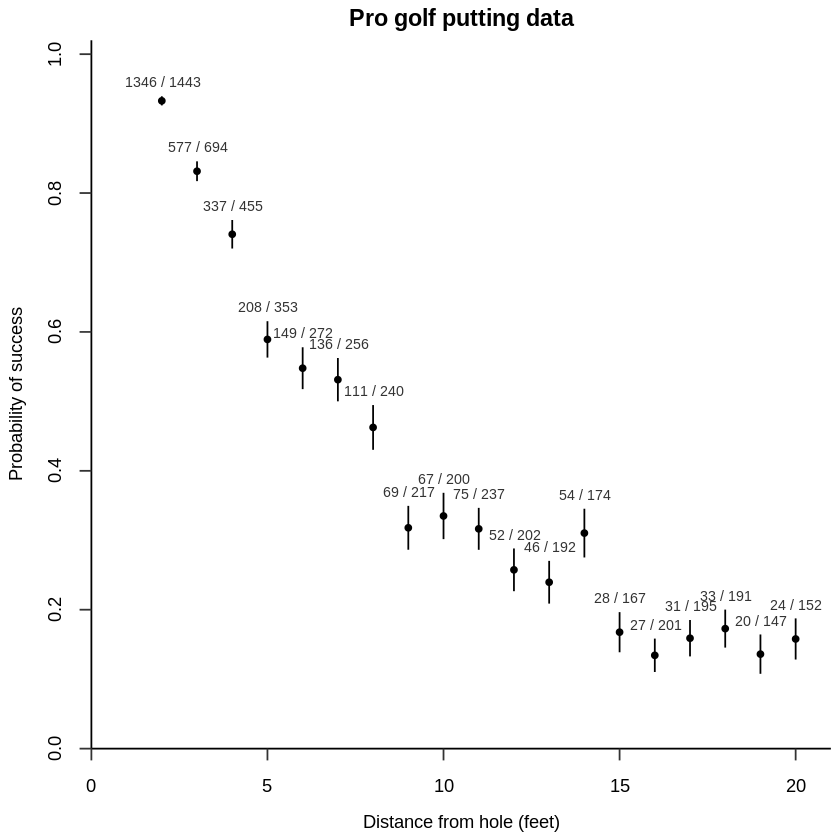

In [0]:
#@title
library(ggplot2)
# scatterplot of data with error bars
data_plot <- ggplot(golf, aes(x=x, y=y/n)) +
  geom_point() +
  geom_linerange(aes(ymin=y/n-se, ymax=y/n+se)) +
  scale_x_continuous(limits=c(0,max(x)*1.05), expand=c(0,0)) +
  scale_y_continuous(limits=c(0,1.02), expand=c(0,0), breaks=c(0.0, 0.2,0.4,0.6,0.8,1.0)) +
  labs(x="Distance from hole (feet)", y="Probability of success") +
  theme_classic() +
  theme(axis.text.y = element_text(size=11, angle=90, hjust = 0.5, vjust = 0.5, margin=margin(l=10,r=10), colour="black"),
        axis.text.x = element_text(size=11, angle=0, hjust = 0.5, vjust = 0.5, margin=margin(t=10,b=10), colour="black"),
        axis.ticks.length = unit(0.25, "cm"), plot.title = element_text(hjust = 0.5, face="bold", size=14))

# add title, label success/attempts for each point
golf_data_plot <- data_plot +
  labs(title="Pro golf putting data") +
  geom_text(aes(label = paste(y, n, sep = " / ")), nudge_x = 0.02, nudge_y = golf$se + 0.02, size=3, col="grey20")
golf_data_plot

The error bars associated with each point $j$ in the above graph are
simple binomial standard deviations, &nbsp; $\sqrt{\hat{p}_j(1-\hat{p}_j)/n_j}$, &nbsp; where &nbsp; $\hat{p_j}=y_j/n_j$ &nbsp; is the success rate for putts taken at distance $x_j$.  As $n$ increases, the standard deviation decreases.


## Logistic regression

Can we model the probability of success in golf putting as a function of `x`, the distance from the hole?
The usual statistical practice is to use a simple regression model, in this case, a logistic regression:

$$
y_j\sim\mbox{binomial}(n_j, \mbox{logit}^{-1}(a + bx_j)),
\mbox{ for } j=1,\dots, J.
$$

In Stan, this model is coded as the following:

In [0]:
#@title
if (!file.exists("golf_logistic.stan")) {
  download.file("https://raw.githubusercontent.com/jgabry/bayes-workflow-book/master/stan/golf_logistic.stan",
                destfile="golf_logistic.stan", quiet=T)
}
print_file("golf_logistic.stan")

data {
  int J;
  int n[J];
  vector[J] x;
  int y[J];
}
parameters {
  real a;
  real b;
}
model {
  y ~ binomial_logit(n, a + b*x);
}


Here is the result of fitting this model to the data:


In [0]:
fit_logistic <- stan("golf_logistic.stan", data=list(x=x, y=y, n=n, J=length(x)))
print(fit_logistic, probs=c(0.25, 0.5, 0.75))

Inference for Stan model: golf_logistic.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean   sd      25%      50%      75% n_eff Rhat
a        2.23    0.00 0.06     2.19     2.23     2.27   899    1
b       -0.26    0.00 0.01    -0.26    -0.26    -0.25   875    1
lp__ -3021.18    0.03 1.04 -3021.60 -3020.88 -3020.46  1164    1

Samples were drawn using NUTS(diag_e) at Thu Jan  2 17:32:22 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


Stan has computed the posterior means $\pm$ standard deviations of $a$
and $b$ to be $2.23\pm 0.06$ and $-0.26\pm 0.01$, respectively. The
Monte Carlo standard error of the mean of each of these parameters is
0 (to two decimal places), indicating that the simulations have run
long enough to estimate the posterior means precisely.  The posterior
quantiles give a sense of the uncertainty in the parameters, with 50%
posterior intervals of $[2.19,2.27]$ and $[-0.26,-0.25]$ for $a$ and
$b$, respectively.  Finally, the values of $\widehat{R}$ near 1 tell
us that the simulations from Stan's four simulated chains have mixed
well.

The following graph shows the fit plotted along with the data:


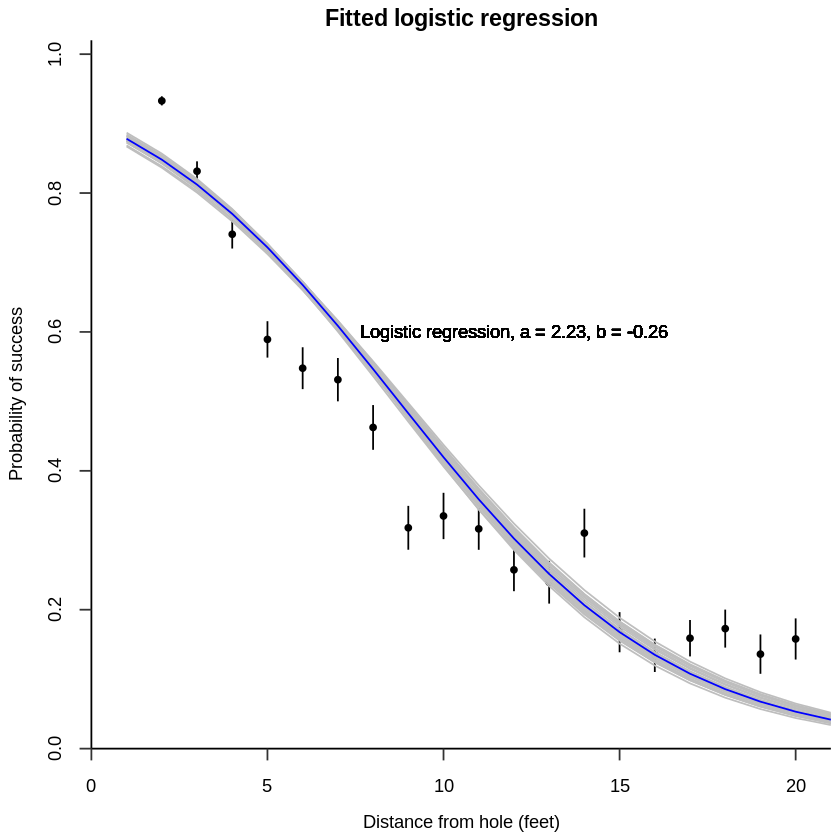

In [0]:
#@title
sims_logistic <- as.matrix(fit_logistic)
a_hat <- median(sims_logistic[,"a"])
b_hat <- median(sims_logistic[,"b"])
x_plus = c(1:21)
median_hat = invlogit(a_hat + b_hat * x_plus)
curve_label = paste("Logistic regression, a = ", round(a_hat, 2), ", b = ", round(b_hat, 2), sep="")
curves = sapply(sample(nrow(sims_logistic), 20), function(i) {invlogit(sims_logistic[i,"a"] + sims_logistic[i,"b"]*x_plus)})
curves_melted = melt(curves)
median_melted = melt(median_hat)
fit_plot <- data_plot + labs(title="Fitted logistic regression")
fit_plot <- fit_plot + geom_text(x=12, y=0.6, label=curve_label)
fit_plot <- fit_plot + geom_line(data=curves_melted, aes(x=Var1, y=value, group=Var2), color="grey")
fit_plot <- fit_plot + geom_line(data=median_melted, aes(x=x_plus, y=value), size=0.5, color="blue")
suppressMessages(print(fit_plot))


The thick line shows the fit corresponding to the posterior median
estimates of the parameters $a$ and $b$; the light lines show 20 draws
from the posterior distribution.



## Modeling from first principles

As an alternative to logistic regression, we shall build a model from
first principles and fit it to the data.  The graph below shows a
simplified sketch of a golf shot.  The dotted line represents the
angle within which the ball of radius $r$ must be hit so that it falls
within the hole of radius $R$.  This threshold angle is
$\sin^{-1}((R-r)/x)$.

<img src="https://raw.githubusercontent.com/jgabry/bayes-workflow-book/master/img/golfpicture.png" width="80%">

The next step is to model human error.  We assume that the golfer is
attempting to hit the ball completely straight but that many small
factors interfere with this goal, so that the actual angle follows a
normal distribution centered at 0 with some standard deviation
$\sigma$.

The probability the ball goes in the hole is then the probability that
the angle is less than the threshold; that is,
$2\Phi(\sin^{-1}((R-r)/x)) - 1$, where $\Phi$ is the cumulative normal
distribution function.

Our model then has two parts:
$$y_j \sim \mbox{binomial}(n_j, p_j)$$
$$p_j = 2\Phi(\sin^{-1}((R-r)/x)) - 1 , \mbox{ for } j=1,\dots, J.$$


Here is the model in Stan:

In [0]:
#@title
if (!file.exists("golf1_vec.stan")) {
  download.file("https://raw.githubusercontent.com/jgabry/bayes-workflow-book/master/stan/golf1_vec.stan",
                destfile="golf1_vec.stan", quiet=T)
}
print_file("golf1_vec.stan")

data {
  int J;
  int n[J];
  vector[J] x;
  int y[J];
  real r;
  real R;
}
transformed data {
  vector[J] asin_R_minus_r_div_x = to_vector(rep_array(asin(R-r), J)) ./ x;
}
parameters {
  real<lower=0> sigma;
}
model {
  vector[J] p = 2*Phi(asin_R_minus_r_div_x / sigma) - 1;
  y ~ binomial(n, p);
}
generated quantities {
  real sigma_degrees;
  sigma_degrees = (180/pi())*sigma;
}



The data $J,n,x,y$ have already been set up as part of running the logistic model above; we just need to define
$r$, the diameter of the golf ball,  and $R$ the diameter of the hole.  The golf ball and hole have diameters 1.68 and 4.25 inches, respectively, which we convert to feet.

In [0]:
r <- (1.68/2)/12
R <- (4.25/2)/12
fit_trig <- stan("golf1_vec.stan", data=list(x=x, y=y, n=n, J=length(x), r=r, R=R))
print(fit_trig, probs=c(0.25, 0.5, 0.75))

Inference for Stan model: golf1_vec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                  mean se_mean   sd      25%      50%      75% n_eff Rhat
sigma             0.03    0.00 0.00     0.03     0.03     0.03  1636    1
sigma_degrees     1.53    0.00 0.02     1.51     1.53     1.54  1636    1
lp__          -2926.68    0.01 0.68 -2926.85 -2926.42 -2926.25  2193    1

Samples were drawn using NUTS(diag_e) at Thu Jan  2 17:54:35 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


The model has a single parameter, $\sigma$.  From the output, we find
that Stan has computed the posterior mean of $\sigma$ to be 0.03
(multiplying this by $180/\pi$, this comes to 1.5 degrees).  The Monte
Carlo standard error of the mean is 0 (to four decimal places),
indicating that the simulations have run long enough to estimate the
posterior mean precisely.  When we print the fit with more precision (argument `digits_summary=5`), we see that the posterior standard deviation is
calculated at 0.0004 (that is, 0.02 degrees), indicating that $\sigma$
itself has been estimated with high precision, which makes sense given
the large number of data points and the simplicity of the model.  The
precise posterior distribution of $\sigma$ can also be seen from the
narrow range of the posterior quantiles.  Finally, $\widehat{R}$ is
near 1, telling us that the simulations from Stan's four simulated
chains have mixed well.

We next plot the data and the fitted model (here using the posterior
median of $\sigma$ but in this case the uncertainty is so narrow that
any reasonable posterior summary would give essentially the same
result), along with the logistic regression fitted earlier:


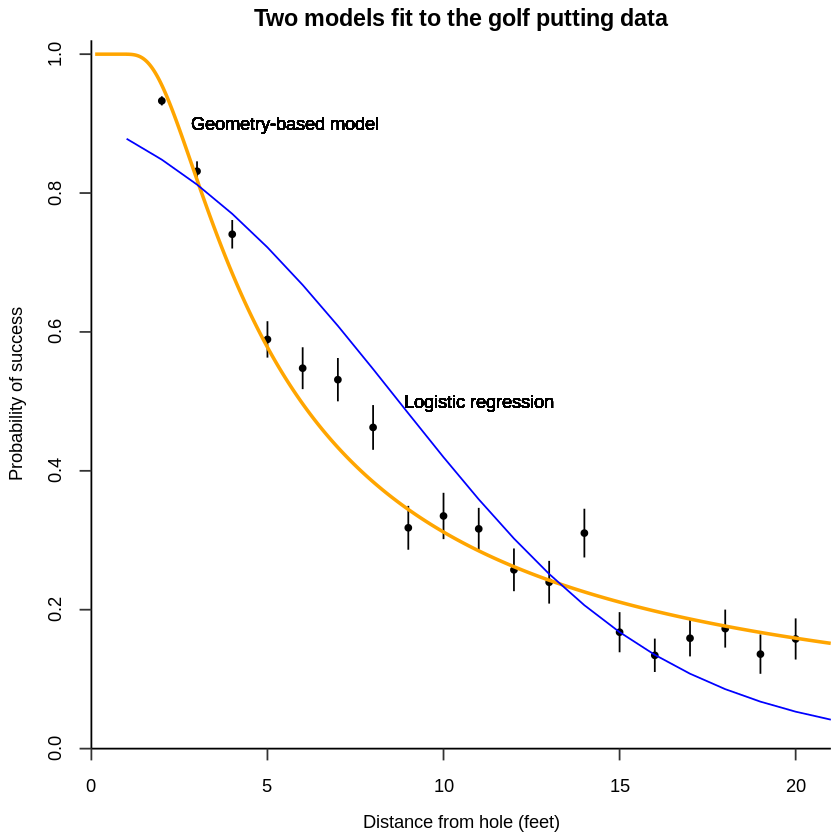

In [0]:
#@title
sims_trig <- as.matrix(fit_trig)
sigma_hat <- median(sims_trig[,"sigma"])

x_grid <- seq(R-r, 1.1*max(x), .01)
p_grid <- 2*pnorm(asin((R-r)/x_grid) / sigma_hat) - 1
df = data.frame(x=x_grid, y=p_grid)
two_plot <- data_plot + labs(title="Two models fit to the golf putting data")
two_plot <- compare_plot + geom_text(x=11, y=0.5, label="Logistic regression")
two_plot <- compare_plot + geom_text(x=5.5, y=0.9, label="Geometry-based model")
two_plot <- compare_plot + geom_line(data=df, aes(x=x, y=y), color="orange", size=1, na.rm=T)
two_plot <- compare_plot + geom_line(data=median_melted, aes(x=x_plus, y=value), size=0.5, color="blue")

suppressMessages(print(compare_plot))


The custom geometry-based model fits the data much better.  This is not to
say that the model is perfect---any experience of golf will reveal
that the angle is not the only factor determining whether the ball
goes in the hole---but it seems like a useful start, and it is good to
know that we can fit nonlinear models by just coding them up in Stan.
